# TransformerEncoder pour la reconnaissance d'images


Ici nous allons utiliser un TransformerEncoder sur le jeu de données CIFAR10 afin de classifier des images. 

In [14]:
#import des ressources

import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## Affichage d'une image :

Files already downloaded and verified


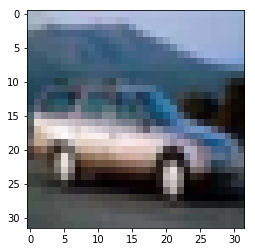

Taille d'image : torch.Size([3, 32, 32])
label : 1


In [15]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

plt.imshow(trainset[4][0].transpose(0,2).transpose(0,1)) #inversion des dimentions pour l'affichage
plt.show()

print('''Taille d'image : {}'''.format(trainset[4][0].size()))
print('''label : {}'''.format(trainset[4][1]))

## Découpage de l'image en 16 sous images de taille 8x8

In [16]:
class Split_image(object):
    
    '''
    
    Transformation de l'image en sous images de taille 8*8
    
    '''
    
    def __init__(self, kernel = 8, stride = 8):
        
        self.kernel = kernel
        self.stride = stride
    
    
    def __call__(self, img):
        
        patches = img.unfold(1, self.kernel, self.stride).unfold(2, self.kernel, self.stride)
        patches = patches.contiguous().view(patches.size(0), -1, self.kernel, self.kernel)
        patches = patches.transpose(0,1)
        
        return patches



    

## Transformation et encodage positionnel

In [17]:
class Split_image_flat_posEncode(object):
    
    '''
    
    Transformation de l'image en sous images de taille 8*8
    puis applatissement des sous images en vecteur de taille 64
    ajout d'un encodage positionel simple sur chaque vecteur.
    
    '''
    
    
    def __init__(self, kernel = 8, stride = 8):
        
        self.kernel = kernel
        self.stride = stride
        
        self.position_vect = torch.range(0,15)/15
        self.position_vect = self.position_vect.unsqueeze(1)
    
    def __call__(self, img):
        
        patches = img.unfold(1, self.kernel, self.stride).unfold(2, self.kernel, self.stride)
        patches = patches.contiguous().view(patches.size(0), -1, self.kernel, self.kernel)
        patches = patches.transpose(0,1)
        patches = patches.flatten(start_dim=1)
        
        patches = torch.cat((patches,self.position_vect),dim = 1)
        
        return patches

## Affichage d'une image découpée

Files already downloaded and verified
Taille d'image : torch.Size([16, 3, 8, 8])


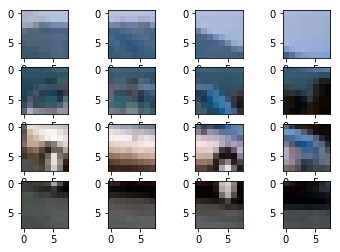

In [18]:
split = Split_image(8,8)

transform = transforms.Compose([transforms.ToTensor(),split])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

for i in range(16):
     
    plt.subplot(4,4,i + 1 )
    plt.imshow(trainset[4][0][i].transpose(0,2).transpose(0,1))

print('''Taille d'image : {}'''.format(trainset[4][0].size()))

## Définition du modèle :

In [43]:
class Net(nn.Module):
    
    
    def __init__(self, n_classes = 10):
        
        super(Net, self).__init__()
        
        self.n_classes = n_classes
        
        self.embedding = nn.Linear(193,193)
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=193,
                                                        nhead=1,
                                                        dim_feedforward=2048,
                                                        dropout=0.1,
                                                        activation='gelu')
        
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        
        self.MLP = nn.Sequential(nn.Linear(193*16,1024),
                                 nn.GELU(),
                                 nn.Linear(1024,1024),
                                 nn.GELU(),
                                 nn.Linear(1024, self.n_classes, bias=False))
        
    def forward(self, inputs):
        
        #inputs: [Batch, seq_len, features] = [Batch, 16, 193]
        
        out = self.embedding(inputs)
        
        out = out.transpose(0,1) #[seq_len, Batch, features]
        
        out = self.transformer_encoder(out) #[seq_len, Batch, features]
        out = out.transpose(0,1) #[Batch, seq_len, features]
        out = out.flatten(start_dim=1) #[Batch, seq_len * features]
        
        out = self.MLP(out) #[Batch, n_classes]
        
        return out

In [44]:
# test

n = Net()
a = torch.rand((8,16,193))

print(n(a).size())

torch.Size([8, 10])


## Entraînement du modèle

In [49]:
EPOCH = 100
BATCH_SIZE = 32
LR = 0.0001
N_CLASSES = 10

device = torch.device("cuda:0")


In [50]:
net = Net(N_CLASSES)
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(reduction = 'sum')

In [51]:
#Données

split = Split_image_flat_posEncode(8,8)

transform = transforms.Compose([transforms.ToTensor(),split])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Files already downloaded and verified
Files already downloaded and verified


In [52]:
losses_train = []
losses_test = []

acc_train = []
acc_test = []

for e in range(EPOCH):
    
    net.train()
    train_loss = 0.0
    correct = 0.0
    total = 0
    
    if e == 50:
        optimizer.param_groups[0]['lr'] = 0.00001
    
    
    for index,(inputs,labels) in enumerate(trainloader):
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        
        total += inputs.size(0) #nombre total d'exemples observés
        
    
    losses_train.append(train_loss/total)
    acc_train.append(correct/total)
    
    #test
    
    net.eval()
    test_loss = 0.0
    total = 0
    correct = 0.0
    
    for index,(inputs,labels) in enumerate(testloader):
        with torch.no_grad():
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            total += inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    
    acc_test.append(correct/total)
    losses_test.append(test_loss/total)
    
    print('Epoch: {} | train: {} | test: {} '.format(e+1,losses_train[-1],losses_test[-1]))
    print('Epoch: {} | acc_train: {} | acc_test: {} '.format(e+1,acc_train[-1],acc_test[-1]))

Epoch: 1 | train: 1.4444190562057495 | test: 1.2218202016830444 
Epoch: 1 | acc_train: 0.4813 | acc_test: 0.562 
Epoch: 2 | train: 1.0636294672393798 | test: 1.0577828779220582 
Epoch: 2 | acc_train: 0.62236 | acc_test: 0.618 
Epoch: 3 | train: 0.8238867914390564 | test: 1.0045724081039429 
Epoch: 3 | acc_train: 0.71036 | acc_test: 0.6455 
Epoch: 4 | train: 0.6021567339134216 | test: 0.9956195738792419 
Epoch: 4 | acc_train: 0.78784 | acc_test: 0.6617 
Epoch: 5 | train: 0.3989513892507553 | test: 1.097713003540039 
Epoch: 5 | acc_train: 0.86128 | acc_test: 0.6574 
Epoch: 6 | train: 0.239616645257473 | test: 1.2257106433868408 
Epoch: 6 | acc_train: 0.91942 | acc_test: 0.6591 
Epoch: 7 | train: 0.15504890548169614 | test: 1.4607050322532653 
Epoch: 7 | acc_train: 0.94802 | acc_test: 0.6574 
Epoch: 8 | train: 0.11108268482416868 | test: 1.5671322686195372 
Epoch: 8 | acc_train: 0.96194 | acc_test: 0.657 
Epoch: 9 | train: 0.09477291798181832 | test: 1.52238395652771 
Epoch: 9 | acc_train

On observe que la loss sur le jeu de test augmente et que l'accuracy stagne autour de 69%. On a ici un phénomène de sur-apprentissage. Pour palier ceci on peu evisager d'augmenter le taux de dropout dans le transformerEncoder, ou d'ajouter des couches de dropout dans le perceptron. On peut aussi envisager de diminuer la taille de notre modèle.